In [1]:
import SimpleITK as sitk
import pathlib
import sys
import pandas as pd
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
sys.path.append("../lib")

ddsm_root_folder  = pathlib.Path('/home/alalbiol/Data/mamo/DDSM_png_1152x896')

In [2]:
def show_mask_image(image_path, mask_path,ax = None, points = None):
    if isinstance(image_path, (pathlib.Path, str)):
        image_path = str(image_path)
        img = np.array(Image.open(image_path))
    else: #ndarray
        img = image_path
        
    if mask_path is None:
        mask = np.zeros_like(img, dtype=np.uint8)
    elif isinstance(mask_path, (pathlib.Path, str)):
        mask = np.array(Image.open(mask_path))
    else: #ndarray
        mask = mask_path
    
    # Create an RGB version of the mask with only the red channel active
    red_mask = np.zeros((*mask.shape, 3), dtype=np.uint8)
    red_mask[:, :, 0] = mask  # Set the red channel to the mask values

    
    # create overlay image, with mask semi-transparent in red
    if ax is None:
        plt.imshow(img, cmap='gray')
        plt.imshow(red_mask, alpha=0.4)
        plt.axis('off')
    else:
        ax.imshow(img, cmap='gray')
        ax.imshow(red_mask, alpha=0.4)
        ax.axis('off')
        
    if points is not None:
        x = points[:,0]
        y = points[:,1]
        ax.plot(x, y, 'b')
        

In [3]:
ddsm_annotations = pd.read_json('../resources/ddsm/ddsm_annotations.json', orient='records', lines=True)


print(ddsm_annotations.iloc[0])

type                                                             MASS
assessment                                                          3
subtlety                                                            3
pathology                                                   MALIGNANT
outline             [[793.3386273398, 793.3386273398, 793.08451503...
bounding_box        [643.9205899036, 648.0270371761, 851.276233692...
breast_malignant                                                 True
image_id             cancers/cancer_13/case4124/D_4124_1.RIGHT_CC.png
mask_id             cancers/cancer_13/case4124/D_4124_1.RIGHT_CC_M...
Name: 0, dtype: object


(1152, 896) (1152, 896)


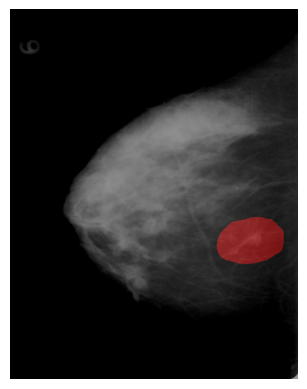

In [4]:
annotation= ddsm_annotations.iloc[0]

image = np.array(Image.open(ddsm_root_folder / annotation['image_id']))
mask = np.array(Image.open(ddsm_root_folder / annotation['mask_id']))

show_mask_image(image, mask)

print(image.shape, mask.shape)


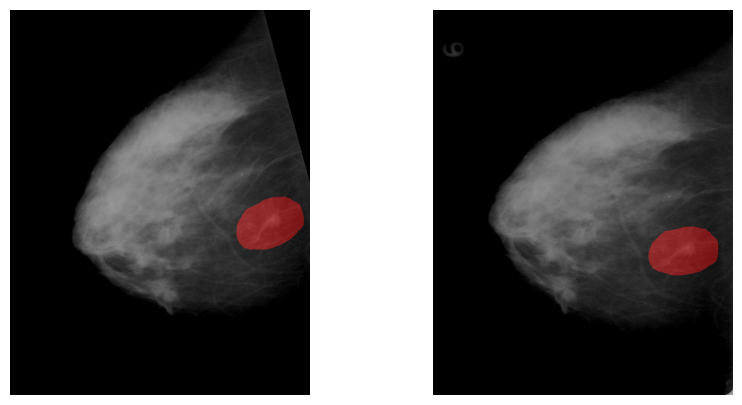

In [5]:
import SimpleITK as sitk
import numpy as np

def rotate_image(image_array: np.ndarray, alpha: float) -> np.ndarray:
    # Convert numpy array to SimpleITK image
    sitk_image = sitk.GetImageFromArray(image_array)
    
    # Get image center as rotation center
    width, height = image_array.shape[1], image_array.shape[0]
    center = [width / 2.0, height / 2.0]

    # Set up rotation transform
    rotation = sitk.Euler2DTransform()
    rotation.SetCenter(center)
    rotation.SetAngle(np.deg2rad(alpha))  # Convert degrees to radians

    # Apply transformation
    rotated_image = sitk.Resample(sitk_image, 
                                sitk_image, 
                                rotation, 
                                sitk.sitkLinear, 
                                0.0, 
                                sitk_image.GetPixelID())

    # Convert rotated SimpleITK image back to numpy array
    rotated_image_array = sitk.GetArrayFromImage(rotated_image)
    
    return rotated_image_array, rotation


rotated_image, rotation = rotate_image(image, 15)
rotated_mask, rotation = rotate_image(mask, 15)

fig, axs = plt.subplots(1, 2, figsize=(10, 5))
show_mask_image(rotated_image, rotated_mask, axs[0])
show_mask_image(image, mask, axs[1])

In [6]:
import SimpleITK as sitk
import numpy as np

def rotate_image_and_points(image_array: np.ndarray, points: np.ndarray, alpha: float) -> (np.ndarray, np.ndarray):
    # Convert numpy array to SimpleITK image
    sitk_image = sitk.GetImageFromArray(image_array)
    
    # Get image dimensions and center as rotation center
    width, height = image_array.shape[1], image_array.shape[0]
    center = [width / 2.0, height / 2.0]

    # Set up rotation transform
    # rotation = sitk.Euler2DTransform()
    # rotation.SetCenter(center)
    # rotation.SetAngle(np.deg2rad(alpha))  # Convert degrees to radians
    
    # print(rotation)
    
    transform = sitk.AffineTransform(2)  # 2D affine transformation
    
    transform.SetCenter(center)
    # Set rotation
    transform.Rotate(0, 1, -np.deg2rad(alpha)) # hay que cambiar el signo?
    transform.Scale([1.1, 1.1])  #scale < 1 amplia
    
    rotation = transform

    # Apply the rotation to the image
    rotated_image = sitk.Resample(sitk_image, 
                                size=[512, 512], 
                                outputOrigin = [400,400],
                                transform = rotation, 
                                interpolator = sitk.sitkLinear, 
                                
                                defaultPixelValue = 0.0, 
                                outputPixelType = sitk_image.GetPixelID())
    
    print("Rotated image origin:", rotated_image.GetOrigin())
    print("Rotated image spacing:", rotated_image.GetSpacing())
    print("Rotated image direction:", rotated_image.GetDirection())

    # Convert rotated image back to numpy array
    rotated_image_array = sitk.GetArrayFromImage(rotated_image)
    
    # Apply the same rotation transform to each point
    inverse_rotation = rotation.GetInverse()
    transformed_points = np.array([inverse_rotation.TransformPoint((x, y)) for x, y in points])
    
    
    
    return rotated_image_array, transformed_points


In [7]:
ddsm_annotations = pd.read_json('../resources/ddsm/ddsm_annotations.json', orient='records', lines=True)


print(ddsm_annotations.iloc[0])

type                                                             MASS
assessment                                                          3
subtlety                                                            3
pathology                                                   MALIGNANT
outline             [[793.3386273398, 793.3386273398, 793.08451503...
bounding_box        [643.9205899036, 648.0270371761, 851.276233692...
breast_malignant                                                 True
image_id             cancers/cancer_13/case4124/D_4124_1.RIGHT_CC.png
mask_id             cancers/cancer_13/case4124/D_4124_1.RIGHT_CC_M...
Name: 0, dtype: object


In [8]:
np.array(annotation['outline']).shape

(2, 2570)

Rotated image origin: (400.0, 400.0)
Rotated image spacing: (1.0, 1.0)
Rotated image direction: (1.0, 0.0, 0.0, 1.0)
Rotated image origin: (400.0, 400.0)
Rotated image spacing: (1.0, 1.0)
Rotated image direction: (1.0, 0.0, 0.0, 1.0)


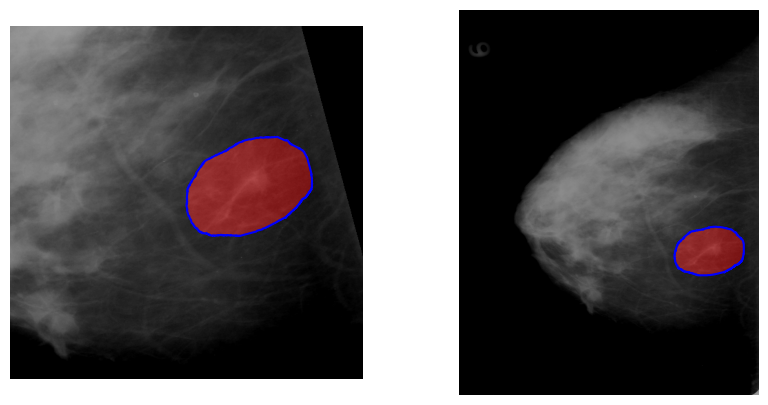

In [9]:
points = np.array(annotation['outline']).T
rotated_image, rotated_points = rotate_image_and_points(image, points, 15)
rotated_mask, rotation_points = rotate_image_and_points(mask, points, 15)

fig, axs = plt.subplots(1, 2, figsize=(10, 5))
show_mask_image(rotated_image, rotated_mask, axs[0], rotated_points-400)
show_mask_image(image, mask, axs[1], points)


In [10]:
print(points[0])
print(rotated_points[0])

[793.33862734 783.86180999]
[800.15463103 677.27170618]


In [11]:
import SimpleITK as sitk
import numpy as np

import SimpleITK as sitk
import numpy as np

def generate_affine_transform(image_size, rotation_angle, shear_x=0, shear_y=0, scale_x=1.0, scale_y=1.0):
    # Get image dimensions
    height, width = image_size

    # Calculate the center of the image
    center_x, center_y = width / 2, height / 2

    # Random rotation angle between -30 and 30 degrees
    rotation_angle = np.deg2rad(rotation_angle) # Convert to radians

    # Random shear values in x and y directions
    #shear_x = np.random.uniform(-0.2, 0.2)
    #shear_y = np.random.uniform(-0.2, 0.2)

    # Random scaling factors
    #scale_x = np.random.uniform(0.8, 1.2)
    #scale_y = np.random.uniform(0.8, 1.2)

    # Create the transformation matrix
    transform = sitk.AffineTransform(2)  # 2D affine transformation
    
    transform.SetCenter([center_x, center_y])
    # Set rotation
    transform.Rotate(0, 1, rotation_angle)
    
    
    rotation = sitk.Euler2DTransform()
    rotation.SetCenter([center_x, center_y])
    rotation.SetAngle(np.deg2rad(rotation_angle))  # Convert degrees to radians
    
    print(rotation)

    # Set shear (the shear affects the matrix entries)
    #transform.SetMatrix([1 + shear_x, shear_y, shear_x, 1 + shear_y])

    # Combine scaling
    # transform.SetMatrix([
    #     (scale_x + shear_x), shear_y,
    #     shear_x, (scale_y + shear_y)
    # ])

    # Translate back to original center
    #transform.Translate([center_x, center_y])

    return transform

# Example usage
image_size = (256, 256)  # Example image size (height, width)
random_transform = generate_affine_transform(image_size,15)
print(random_transform)


itk::simple::Euler2DTransform
 Euler2DTransform (0x47a5fd0)
   RTTI typeinfo:   itk::Euler2DTransform<double>
   Reference Count: 1
   Modified Time: 1878
   Debug: Off
   Object Name: 
   Observers: 
     none
   Matrix: 
     0.99999 -0.00456925 
     0.00456925 0.99999 
   Offset: [0.5862, -0.583527]
   Center: [128, 128]
   Translation: [0, 0]
   Inverse: 
     0.99999 0.00456925 
     -0.00456925 0.99999 
   Singular: 0
   Angle: 0.00456926

itk::simple::AffineTransform
 AffineTransform (0x1a12ec60)
   RTTI typeinfo:   itk::AffineTransform<double, 2u>
   Reference Count: 1
   Modified Time: 1873
   Debug: Off
   Object Name: 
   Observers: 
     none
   Matrix: 
     0.965926 0.258819 
     -0.258819 0.965926 
   Offset: [-28.7673, 37.4903]
   Center: [128, 128]
   Translation: [0, 0]
   Inverse: 
     0.965926 -0.258819 
     0.258819 0.965926 
   Singular: 0



# Sampling positive patch using outline

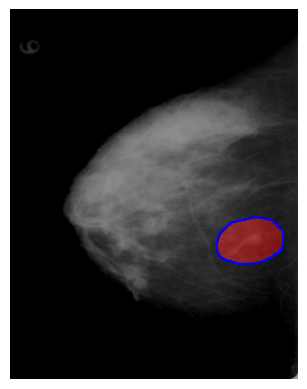

In [12]:
annotation= ddsm_annotations.iloc[0]

image = np.array(Image.open(ddsm_root_folder / annotation['image_id']))
mask = np.array(Image.open(ddsm_root_folder / annotation['mask_id']))



points = np.array(annotation['outline']).T
show_mask_image(image, mask)
plt.plot(points[:,0], points[:,1], 'b')


Number of points in outline= 2570
 sampled abn at (704, 662)
 sampled abn at (829, 765)
 sampled abn at (823, 765)


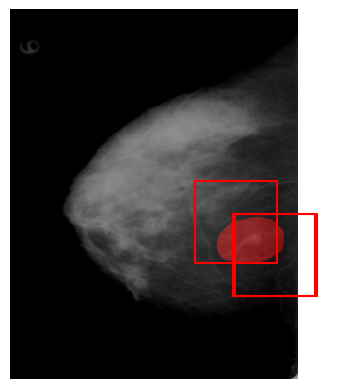

In [13]:
from sample_patches_main import sample_positive_bb

bbs = sample_positive_bb(points, patch_size=256,
                pos_cutoff=.75, 
                nb_abn=3, 
                verbose=True)


show_mask_image(image, mask)

import matplotlib.patches as patches
for bb in bbs:
    # obverlap bb with image
    x = bb[0]
    y = bb[1]
    w = bb[2]
    h = bb[3]
    
    xmin = x-w//2
    ymin = y-h//2
    xmax = x+w//2
    ymax = y+h//2
    
    plt.plot([xmin, xmax, xmax, xmin, xmin], [ymin, ymin, ymax, ymax, ymin], 'r')

    #overlap patch with image
    #rect = patches.Rectangle((x-w//2, y-h//2), w, h, linewidth=1, edgecolor='r', facecolor='none')
    #plt.gca().add_patch(rect)


Number of points in outline= 2570
 sampled abn at (766, 565)


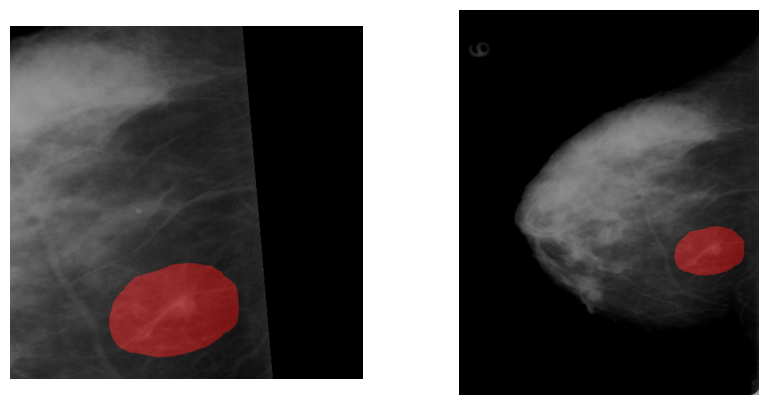

In [14]:

transform = sitk.AffineTransform(2)  # 2D affine transformation

center = np.mean(points, axis=0)
alpha = np.random.uniform(-15, 15)


transform.SetCenter(center)
# Set rotation
transform.Rotate(0, 1, -np.deg2rad(alpha)) # hay que cambiar el signo?
transform.Scale([1.1, 1.1])  #scale < 1 amplia

    
# Apply the same rotation transform to each point
inverse_transform = rotation.GetInverse()
transformed_points = np.array([inverse_transform.TransformPoint((x, y)) for x, y in points])

bbs = sample_positive_bb(transformed_points, patch_size=512,
                pos_cutoff=.75, 
                nb_abn=1, 
                verbose=True)
 

sitk_image = sitk.GetImageFromArray(image) 
sitk_mask = sitk.GetImageFromArray(mask)

output_center = bbs[0][:2]
output_size = bbs[0][2:]
output_origin = [output_center[0]-output_size[0]//2, output_center[1]-output_size[1]//2]

rotated_image = sitk.Resample(sitk_image, 
                            size=output_size, 
                            outputOrigin = output_origin,
                            transform = transform, 
                            interpolator = sitk.sitkLinear, 
                            defaultPixelValue = 0.0, 
                            outputPixelType = sitk_image.GetPixelID())

rotated_mask = sitk.Resample(sitk_mask, 
                            size=output_size, 
                            outputOrigin = output_origin,
                            transform = transform, 
                            interpolator = sitk.sitkLinear, 
                            defaultPixelValue = 0.0, 
                            outputPixelType = sitk_mask.GetPixelID())

rotated_image_array = sitk.GetArrayFromImage(rotated_image)
rotated_mask_array = sitk.GetArrayFromImage(rotated_mask)

fig, axs = plt.subplots(1, 2, figsize=(10, 5))
show_mask_image(rotated_image_array, rotated_mask_array, axs[0])
show_mask_image(image, mask, axs[1])


In [15]:
transform = sitk.AffineTransform(2)  # 2D affine transformation

center = np.mean(points, axis=0)
alpha = np.random.uniform(-0.001, 0.001)

alpha = 0

transform.SetCenter(center)
# Set rotation
transform.Rotate(0, 1, -np.deg2rad(alpha)) # hay que cambiar el signo?
transform.Scale([1.1, 1.1])  #scale < 1 amplia
transform.Shear(0, 1, 0.1)


print(transform.GetMatrix())

(1.1, 0.11000000000000001, 0.0, 1.1)


# Test sample negative

Number of points in outline= 2570
 sampled abn at (863, 559)
 sampled abn at (468, 935)
 sampled abn at (824, 149)


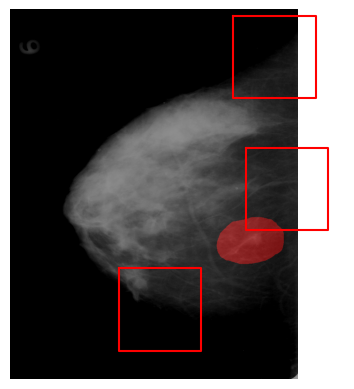

In [62]:
from sample_patches_main import sample_negative_bb

bbs = sample_negative_bb(points, patch_size=256,
                neg_cutoff=.2, 
                im_size=(image.shape[1], image.shape[0]),
                nb_bkg=3, 
                verbose=True)


show_mask_image(image, mask)

import matplotlib.patches as patches
for bb in bbs:
    # obverlap bb with image
    x = bb[0]
    y = bb[1]
    w = bb[2]
    h = bb[3]
    
    xmin = x-w//2
    ymin = y-h//2
    xmax = x+w//2
    ymax = y+h//2
    
    plt.plot([xmin, xmax, xmax, xmin, xmin], [ymin, ymin, ymax, ymax, ymin], 'r')


# Test Hard negatives

from sample_patches_main import sample_hard_negative_bb

bbs = sample_hard_negative_bb(points, patch_size=256,
                neg_cutoff=.2, 
                im_size=(image.shape[1], image.shape[0]),
                nb_bkg=3, 
                verbose=True)


show_mask_image(image, mask)

import matplotlib.patches as patches
for bb in bbs:
    # obverlap bb with image
    x = bb[0]
    y = bb[1]
    w = bb[2]
    h = bb[3]
    
    xmin = x-w//2
    ymin = y-h//2
    xmax = x+w//2
    ymax = y+h//2
    
    plt.plot([xmin, xmax, xmax, xmin, xmin], [ymin, ymin, ymax, ymax, ymin], 'r')
